# Train a Variational Autoencoder to compress AmSynth's parameter space into a latent representation.

In [2]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas.plotting import parallel_coordinates
from torch.utils.data import DataLoader
import timbral_models
import csv
import os
from torch.optim import Adam
from torch import argmax

import torch
import torch.nn as nn

# SET RANDOM SEEDs FOR REPRODUCIBILITY
torch.manual_seed(0)
np.random.seed(0)


## Step 1: Dataset Pre-Processing

In [3]:
class SynthPresetsDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

        # TODO: Fix this
        if len(self.data) != len(self.labels):
            raise Exception(
                "The length of 'data' does not match the length of 'labels'")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X = self.data[index]
        y = self.labels[index]

        return X, y



The `loadData(...argmax())` function is responsible for parsing the .csv file that contains each of the amsynth presets we currently have.

This function does the following:

- Drops columns we don't want to learn (master volume, for example)
- Determines which columns are categorical data.
- Converts categorical data into one-hot-encoded vectors.
- Normalizes our data between 0 and 1 for better training of ML model.
- Splits into X & y components and returns those values.


In [4]:
def loadData(path, DEBUG=False):
    added_cols = []
    minmax = {}
    df = pd.read_csv(path)  # Read from the CSV file

    # Uncomment when debugging.
    # df = df.head(5)

    # Drop these columms, as we don't need / want to learn them
    df = df.drop("portamento_mode", axis=1)
    df = df.drop("portamento_time", axis=1)
    df = df.drop("keyboard_mode", axis=1)
    df = df.drop("filter_vel_sens", axis=1)
    df = df.drop("amp_vel_sens", axis=1)
    df = df.drop("master_vol", axis=1)
    df = df.drop("distortion_crunch", axis=1)

    # Determine which columns are "categorical" rather than continuous
    categorical = ["osc1_waveform", "osc2_waveform", "lfo_waveform",
                   "osc2_sync", "filter_type", "filter_slope", "freq_mod_osc"]

    # Replace all NAN in the freq_mod_osc column with 0
    df['freq_mod_osc'] = df['freq_mod_osc'].replace(np.nan, 0)
    df['freq_mod_osc'] = df['freq_mod_osc'].astype(np.int32)

    for col in categorical:
        if col == 'portamento_time':
            continue  # Don't add portamento time

        newOH = pd.get_dummies(pd.Categorical(
            df[col], categories=getCategories(col)), prefix=col, dtype=np.int32)
        del df[col]  # Remove the original (non-encoded) from the dataframe
        for i in newOH.columns:
            added_cols.append(i)

            # Convert to numpy array for next step
            np_arr = newOH[i].to_numpy()
            df[i] = np_arr  # Set dataframe column with updated numpy array.

    df.fillna(0, inplace=True)  # Replace empty values with 0

    labels = df['preset_name']  # Split out the labels

    data = df.iloc[:, 1:].astype(np.float32)  # Split out the Data

    # Normalize data between 0 and 1.
    for colum in data.columns:
        if colum in added_cols:
            # print("skipping:", colum)
            continue

        min = data[colum].min()
        max = data[colum].max()

        minmax[colum] = (min, max)

        if max-min != 0:  # If the max and min values are not the same
            data[colum] = (data[colum] - min) / (max-min)

    X = torch.tensor(data.values)  # Store as PyTorch tensor
    y = labels.to_numpy()  # Store as strings in Numpy Array

    return X, y, data, minmax

# This function returns how many options are in one category, taken from the amsynth spec (source code).


def getCategories(parameter_name):
    if parameter_name == 'osc1_waveform':
        return [i for i in range(5)]
    if parameter_name == 'osc2_waveform':
        return [i for i in range(5)]
    if parameter_name == 'lfo_waveform':
        return [i for i in range(7)]
    if parameter_name == 'osc2_sync':
        return [i for i in range(2)]
    if parameter_name == 'filter_type':
        return [i for i in range(5)]
    if parameter_name == 'filter_slope':
        return [i for i in range(2)]
    if parameter_name == 'freq_mod_osc':
        return [i for i in range(3)]


X, y, data, minmax = loadData("./amSynthData/amsynth_presets.csv")

# print(len(data.columns) == len(X[0]))  # Should be TRUE

"""
This is just a gut check for normalization between 0 and 1
"""
ALL_GOOD = True
for col in data.columns:
    if data[col].min() != 0:
        if len(data[col].unique()) != 1:
            ALL_GOOD = False
            break
    if data[col].max() != 1:
        if len(data[col].unique()) != 1:
            ALL_GOOD = False
            break


print("ALL_GOOD:", ALL_GOOD)


# Load datasets

dataset_test = SynthPresetsDataset(X[:200], y[:200])
dataset_train = SynthPresetsDataset(X[200:], y[200:])

ALL_GOOD: True


## Step 2: Define Model Architecture and Hyperparameters

### Model Architecture Defined here

In [5]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.Tanh()

        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.Tanh()

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        # takes exponential function (log var -> var)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var


### Hyperparameters defined here

In [6]:
cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 32
x_dim = 56
hidden_dim = 32
latent_dim = 2

lr = 5e-4

epochs = 500


### Loss Function Definition

In [7]:

def loss_function(x, x_hat, mean, log_var):

    # MSE for continuous features
    MSE = nn.functional.mse_loss(
        x_hat[:, :27], x[:, :27], reduction='sum')

    # osc1_waveform -- x[27:32]
    osc1_waveform_loss = nn.functional.cross_entropy(
        x_hat[:, 27:32],
        argmax(x[:, 27:32], dim=1),
        reduction='sum'
    )

    # osc2_waveform -- x[32:37]
    osc2_waveform_loss = nn.functional.cross_entropy(
        x_hat[:, 32:37],
        argmax(x[:, 32:37], dim=1),
        reduction='sum'
    )

    # lfo_waveform -- x[37:44]
    lfo_waveform_loss = nn.functional.cross_entropy(
        x_hat[:, 35:42],
        argmax(x[:, 35:42], dim=1),
        reduction='sum'
    )

    # osc2_sync -- x[44:46]
    osc2_sync_loss = nn.functional.cross_entropy(
        x_hat[:, 44:46],
        argmax(x[:, 44:46], dim=1),
        reduction='sum'
    )

    # filter_type -- x[46:51]
    filter_type_loss = nn.functional.cross_entropy(
        x_hat[:, 46:51],
        argmax(x[:, 46:51], dim=1),
        reduction='sum'
    )

    # filter_slope -- x[51:53]
    filter_slope_loss = nn.functional.cross_entropy(
        x_hat[:, 51:53],
        argmax(x[:, 51:53], dim=1),
        reduction='sum'
    )

    # freq_mod_osc -- x[53:56]
    freq_mod_osc_loss = nn.functional.cross_entropy(
        x_hat[:, 53:56],
        argmax(x[:, 53:56], dim=1),
        reduction='sum'
    )

    # KLD for distributions
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    # SUM all of loss functions
    return (MSE / 27) \
        + (osc1_waveform_loss
           + osc2_waveform_loss
           + lfo_waveform_loss
           + osc2_sync_loss
           + filter_type_loss
           + filter_slope_loss
           + freq_mod_osc_loss) / 7 \
        + 0.0001 * KLD

## Step 3: Train the VAE

In [8]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

optimizer = Adam(model.parameters(), lr=lr)

kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last': True}
train_loader = DataLoader(dataset=dataset_train,
                            batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=dataset_test,
                            batch_size=batch_size, shuffle=True, **kwargs)

print("Start training VAE with latent dimension ({})...".format(str(latent_dim)))
model.train()


latent_x, latent_y = [], []
min_val, max_val = -4, 4
points = 50

df = pd.DataFrame()
df['X'] = latent_x
df['Y'] = latent_y

# Create a grid evenly spaced over LS.
for i in range(points):
    for j in range(points):
        latent_x.append (min_val + 8/points*i)
        latent_y.append(min_val + 8/points*j)


losses = []
validations = []

# idx = 0

for epoch in range(epochs+1):
    overall_loss = 0
    overall_val_loss = 0
    
    # Train model with train set
    for batch_idx, (x, _) in enumerate(train_loader):
        
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    losses.append(overall_loss / (batch_idx*batch_size))
    if epoch % 100 == 0: # Don't print every epoch
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Training Loss: ", overall_loss / (batch_idx*batch_size))
        
        
        c = []
        for coord in zip(latent_x, latent_y):
            decoded = model.Decoder(torch.tensor(coord))
            c.append(decoded[10].item()) # decoded[10] is the cutoff frequency parameter. Just an example!
                       
        df['epoch{}'.format(epoch)] = c

    
    # Validate model with test set
    for batch_val_idx, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        overall_val_loss += loss.item()
        
    validations.append(overall_val_loss / (batch_val_idx*batch_size))
    if epoch % 100 == 0: # Don't print every epoch
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Validation Loss: ", overall_val_loss / (batch_val_idx*batch_size))
    
print("Finish!!")


Start training VAE with latent dimension (2)...


	Epoch 1 complete! 	Average Training Loss:  1.4145661935414353
	Epoch 1 complete! 	Average Validation Loss:  1.5145058393478394
	Epoch 101 complete! 	Average Training Loss:  0.9736728994813684
	Epoch 101 complete! 	Average Validation Loss:  1.1217636585235595
	Epoch 201 complete! 	Average Training Loss:  0.9441352404960214
	Epoch 201 complete! 	Average Validation Loss:  1.0907008290290832
	Epoch 301 complete! 	Average Training Loss:  0.9358839621282604
	Epoch 301 complete! 	Average Validation Loss:  1.087588632106781
	Epoch 401 complete! 	Average Training Loss:  0.9306022630978937
	Epoch 401 complete! 	Average Validation Loss:  1.0824644565582275
	Epoch 501 complete! 	Average Training Loss:  0.9277097680797316
	Epoch 501 complete! 	Average Validation Loss:  1.080082106590271
Finish!!


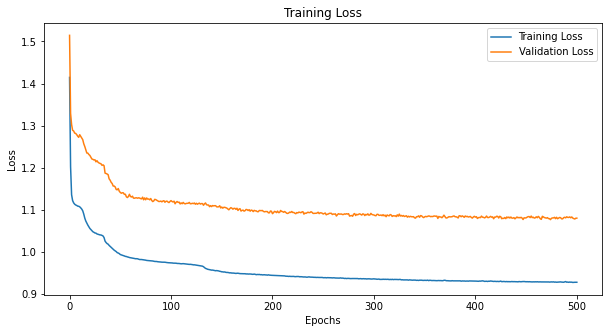

In [9]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Training Loss")
plt.plot(validations,label="Validation Loss")
# plt.ylim((-0.5,3))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.savefig("losscurves.svg", format="svg")
plt.show()

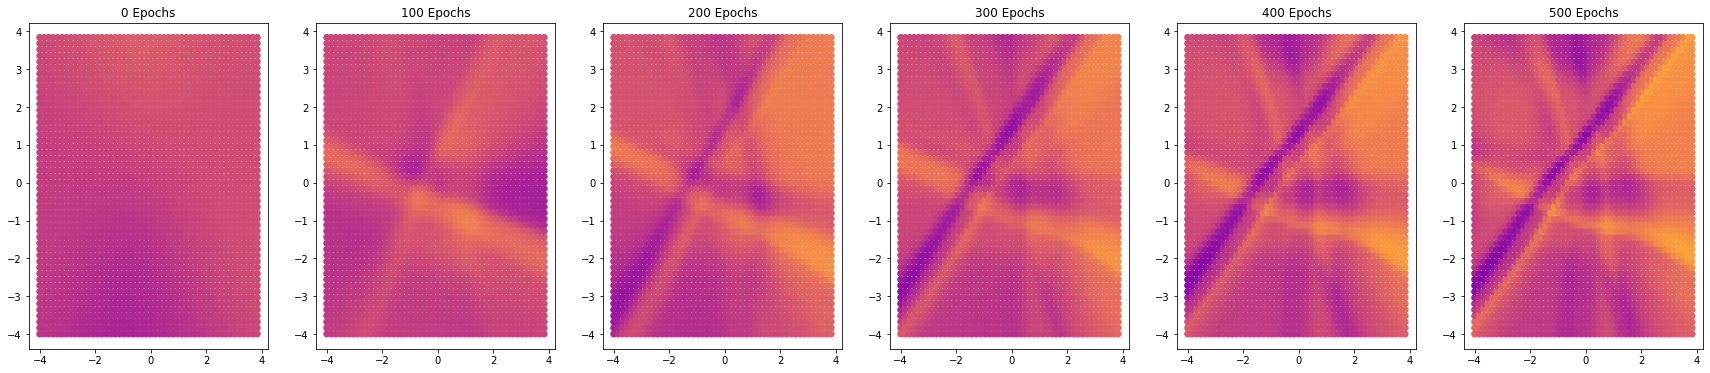

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(30,6))

for idx, col in enumerate(df.columns[2:]):
    fig.axes[idx].scatter(latent_x,latent_y, c=df[col], cmap="plasma", vmin=0, vmax=1)
    fig.axes[idx].set_title("{} Epochs".format(idx * 100))

# plt.savefig("latentstructemerges.svg", format="svg")

plt.show()

### Save Model for re-use

In [11]:
# torch.save(model, "trained_vae.pt")

## Step 4: Evaluate VAE

### Visualize Latent Space

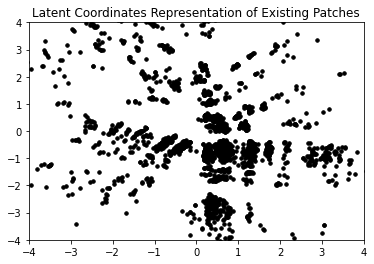

In [17]:
latent_space_coords = []

for idx, x in enumerate(X):
    latent_space_coords.append(model.Encoder(x)[0].detach().numpy())

df_latent_coords = pd.DataFrame(latent_space_coords)
df_latent_coords.columns = ["X", "Y"]

plt.scatter(df_latent_coords['X'], df_latent_coords['Y'], c="black", s = 12)
plt.title("Latent Coordinates Representation of Existing Patches")
plt.ylim((-4,4))
plt.xlim((-4,4))
plt.xticks(np.arange(-4, 5, 1.0))
plt.yticks(np.arange(-4, 5, 1.0))

plt.show()

### Save the latent vis CSV file.

This helps to transfer the visualization to the latent space explorer

## Step 5: Timbral Analysis

Todo: Add this code to the experimental notebook

In [ ]:
def format_bank(preset_dicts, bank_name="latentspace"):
    f = open("./latent_patches/" + bank_name + ".amSynth.bank", "w")
    f.write("amSynth\n") # Print Header
    
    for preset in preset_dicts:
        for i in preset:
            if i == "preset_name":
                f.write("<preset> <name> {}\n".format(preset[i]))
            else:
                f.write("<parameter> {} {}\n".format(i, preset[i]))
        # print(preset)
    f.write("EOF")


def format_preset(preset_name="preset", preset_dict={}):
    f = open("./" + preset_name + ".amSynthPreset", "w")
    f.write("amSynth1.0preset\n")  # Print Header to file

    for i in preset_dict:
        if i == "preset_name":
            f.write("<preset> <name> {}\n".format(preset_name))
        else:
            f.write("<parameter> {} {}\n".format(i, preset_dict[i]))
    print("Preset ", preset_name+".amSynthPreset", " successfully generated!")


# This function is used to re-scale the data into the correct format.
def unnormalize(normalized_value, minmax):
    return format(normalized_value * (minmax[1] - minmax[0]) + minmax[0], '.4f')


# TODO: USE THIS FUNCTION BELOW ->
def build_format_preset(data, minmax, name="recons", generate_preset=False):

    PH_COLS = ['amp_attack', 'amp_decay', 'amp_sustain', 'amp_release',
               'filter_attack', 'filter_decay', 'filter_sustain', 'filter_release',
               'filter_resonance', 'filter_env_amount', 'filter_cutoff', 'osc2_detune',
               'lfo_freq', 'osc2_range', 'osc_mix', 'freq_mod_amount',
               'filter_mod_amount', 'amp_mod_amount', 'osc_mix_mode',
               'osc1_pulsewidth', 'osc2_pulsewidth', 'reverb_roomsize', 'reverb_damp',
               'reverb_wet', 'reverb_width', 'osc2_pitch', 'filter_kbd_track',
               'osc1_waveform_0', 'osc1_waveform_1', 'osc1_waveform_2',
               'osc1_waveform_3', 'osc1_waveform_4', 'osc2_waveform_0',
               'osc2_waveform_1', 'osc2_waveform_2', 'osc2_waveform_3',
               'osc2_waveform_4', 'lfo_waveform_0', 'lfo_waveform_1', 'lfo_waveform_2',
               'lfo_waveform_3', 'lfo_waveform_4', 'lfo_waveform_5', 'lfo_waveform_6',
               'osc2_sync_0', 'osc2_sync_1', 'filter_type_0', 'filter_type_1',
               'filter_type_2', 'filter_type_3', 'filter_type_4', 'filter_slope_0',
               'filter_slope_1', 'freq_mod_osc_0', 'freq_mod_osc_1', 'freq_mod_osc_2']

    # Rebuild Continuous Columns via un-normalization.
    cols = ['amp_attack', 'amp_decay', 'amp_sustain', 'amp_release', 'filter_attack', 'filter_decay', 'filter_sustain', 'filter_release', 'filter_resonance', 'filter_env_amount', 'filter_cutoff', 'osc2_detune', 'lfo_freq', 'osc2_range',
            'osc_mix', 'freq_mod_amount', 'filter_mod_amount', 'amp_mod_amount', 'osc_mix_mode', 'osc1_pulsewidth', 'osc2_pulsewidth', 'reverb_roomsize', 'reverb_damp', 'reverb_wet', 'reverb_width', 'osc2_pitch', 'filter_kbd_track']
    
    preset_dict = {'preset_name': name}
    for i in cols:
        preset_dict[i] = unnormalize(data[PH_COLS.index(i)].item(), minmax[i])

    # Rebuild Categorical columns via arg-max
    preset_dict['osc1_waveform'] = torch.argmax(
        data[PH_COLS.index('osc1_waveform_0'):PH_COLS.index('osc1_waveform_4')]).item()
    preset_dict['osc2_waveform'] = torch.argmax(
        data[PH_COLS.index('osc2_waveform_0'):PH_COLS.index('osc2_waveform_4')]).item()
    preset_dict['lfo_waveform'] = torch.argmax(
        data[PH_COLS.index('lfo_waveform_0'):PH_COLS.index('lfo_waveform_6')]).item()
    preset_dict['osc2_sync'] = torch.argmax(
        data[PH_COLS.index('osc2_sync_0'):PH_COLS.index('osc2_sync_1')]).item()
    preset_dict['filter_type'] = torch.argmax(
        data[PH_COLS.index('filter_type_0'):PH_COLS.index('filter_type_4')]).item()
    preset_dict['filter_slope'] = torch.argmax(
        data[PH_COLS.index('filter_slope_0'):PH_COLS.index('filter_slope_1')]).item()
    preset_dict['freq_mod_osc'] = torch.argmax(
        data[PH_COLS.index('freq_mod_osc_0'):PH_COLS.index('freq_mod_osc_2')]).item()

    # Rebuild non-learned columns (Statically)
    preset_dict['portamento_mode'] = 0
    preset_dict['portamento_time'] = 0
    preset_dict['keyboard_mode'] = 0
    preset_dict['filter_vel_sens'] = 1
    preset_dict['amp_vel_sens'] = 1
    preset_dict['distortion_crunch'] = 0
    preset_dict['master_vol'] = 0.6

    if generate_preset:
        format_preset(name, preset_dict)
    else:
        return preset_dict

minmax = {'amp_attack': (0.0, 2.5),
 'amp_decay': (0.0, 2.4966),
 'amp_sustain': (0.0, 1.0),
 'amp_release': (0.0, 2.5),
 'filter_attack': (0.0, 2.5),
 'filter_decay': (0.0, 2.49172),
 'filter_sustain': (0.0, 1.0),
 'filter_release': (0.0, 2.5),
 'filter_resonance': (0.0, 0.97),
 'filter_env_amount': (-16.0, 16.0),
 'filter_cutoff': (-0.5, 1.5),
 'osc2_detune': (-1.0, 1.0),
 'lfo_freq': (0.0, 7.5),
 'osc2_range': (-3.0, 4.0),
 'osc_mix': (-1.0, 1.0),
 'freq_mod_amount': (0.0, 1.25992),
 'filter_mod_amount': (-1.0, 1.0),
 'amp_mod_amount': (-1.0, 1.0),
 'osc_mix_mode': (0.0, 1.0),
 'osc1_pulsewidth': (0.0, 1.0),
 'osc2_pulsewidth': (0.0, 1.0),
 'reverb_roomsize': (0.0, 1.0),
 'reverb_damp': (0.0, 1.0),
 'reverb_wet': (0.0, 1.0),
 'reverb_width': (0.0, 1.0),
 'osc2_pitch': (-12.0, 12.0),
 'filter_kbd_track': (0.0, 1.0)}

This generates the patches when sampling the latent space.

In [ ]:
# x, y = [], []
# min_val, max_val = -4, 4
# points = 50

# presets = []

# # Create a grid evenly spaced over LS.
# for i in range(points):
#     for j in range(points):
#         x.append (min_val + 8/points*i)
#         y.append(min_val + 8/points*j)
        
# for coord in zip(x, y):
#     decoded = model.Decoder(torch.tensor(coord))
#     presets.append(build_format_preset(decoded, minmax, name="{},{}".format(round(coord[0],2), round(coord[1],2))))

    
# def split(list_a, chunk_size):
#   for i in range(0, len(list_a), chunk_size):
#     yield list_a[i:i + chunk_size]

# print(len(presets))
# chunk_size = 128
# for idx, bank in enumerate(list(split(presets, chunk_size))):
#     format_bank(bank, "sampleLS{}".format(idx))

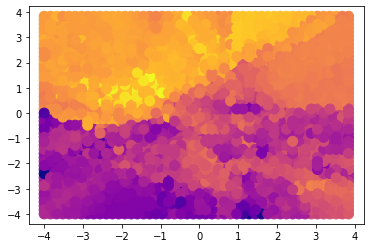

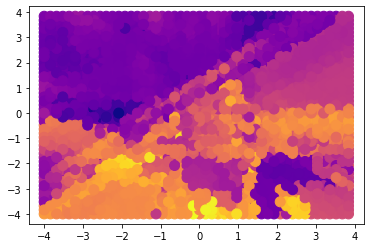

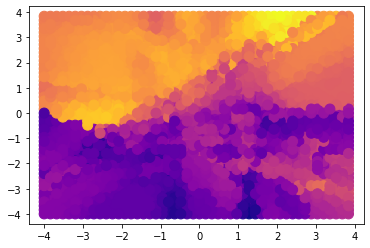

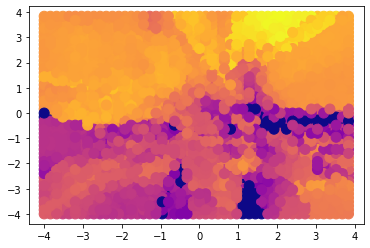

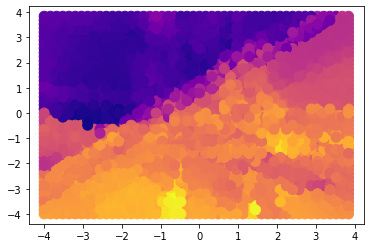

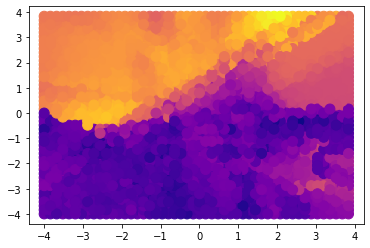

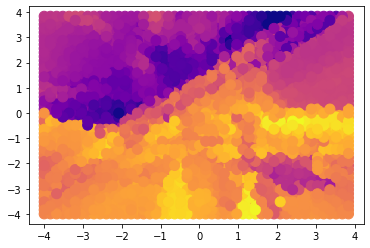

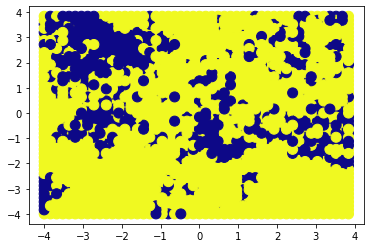

In [ ]:
# df = pd.read_csv("./new_LatentSpaceWavFiles.csv")

# for i in df.columns[2:]:
#     plt.scatter(df["x"], df['y'], c=df[i], cmap="plasma", s=100)
#     plt.show()

This generates both the real and reconstructed patches (matching pairs)

In [ ]:
# presets = []
# for idx, x in enumerate(X_test[:128]):
#     presets.append(build_format_preset(data=x, minmax=minmax, name="realpatch{}".format(str(idx))))
# format_bank(presets, 'real_patches')


# presets = []
# for idx, x in enumerate(X_test[:128]):
#     presets.append(build_format_preset(data=model(x)[0].detach(), minmax=minmax, name="reconstructionpatch{}".format(str(idx))))
# format_bank(presets, 'reconstructed_patches')

# Record audio clips.

After recording audio clips, run Timbral Analysis as follows..

(We save timbral analysis values in csv files for reproducibility)

This code block takes ~20 minutes to run.

In [ ]:
# with open("new_timbral_real2.csv", "w") as f:
    
#     writer = csv.writer(f)
#     header = ["hardness", "depth", "brightness", "roughness", "warmth", "sharpness", "boominess", "reverb"]
#     writer.writerow(header)
#     count = 0        
#     for file in os.listdir("./WavFilesReal"):
#         count += 1
#         if count % 10 == 0:
#             print(count)
#         try:
#             row = timbral_models.timbral_extractor("./WavFilesReal/{}".format(file), output_type='list', clip_output=True, verbose=False)
#             writer.writerow(row)
#         except:
#             print("error")

# with open("new_timbral_reconstructed2.csv", "w") as f:
    
#     writer = csv.writer(f)
#     header = ["hardness", "depth", "brightness", "roughness", "warmth", "sharpness", "boominess", "reverb"]
#     writer.writerow(header)
#     count = 0        
#     for file in os.listdir("./WavFilesReconstructed"):
#         count += 1
#         if count % 10 == 0:
#             print(count)
#         try:
#             row = timbral_models.timbral_extractor("./WavFilesReconstructed/{}".format(file), output_type='list', clip_output=True, verbose=False)
#             writer.writerow(row)
#         except:
#             print("error")

This code block takes ~194mins to run.

In [ ]:
# with open("LatentSpaceWavFiles.csv", "w") as f:
    
#     writer = csv.writer(f)
#     header = ["x","y","hardness", "depth", "brightness", "roughness", "warmth", "sharpness", "boominess", "reverb"]
#     writer.writerow(header)
#     count = 0        
#     for file in os.listdir("LatentSpaceWavFiles/"):
#         count += 1
#         if count % 100 == 0:
#             print(count)
#         try:
#             row = timbral_models.timbral_extractor("./LatentSpaceWavFiles/{}".format(file), output_type='list', clip_output=True, verbose=False)
#             row.insert(0, float(file.split(",")[1].removesuffix(".wav")))
#             row.insert(0, float(file.split(",")[0]))
#             writer.writerow(row)
#         except:
#             print("error")

hardness -> mean: 11.74438636119223 std: 8.175604635490833
depth -> mean: 10.957425747387937 std: 7.731504239834061
brightness -> mean: 10.326317144177494 std: 6.656130516964661
roughness -> mean: 17.67114134679473 std: 14.573288259616042
warmth -> mean: 9.697928761078888 std: 7.13188516629057
sharpness -> mean: 12.63982500792449 std: 9.18725544052772
boominess -> mean: 8.336590941370421 std: 7.525860008702007


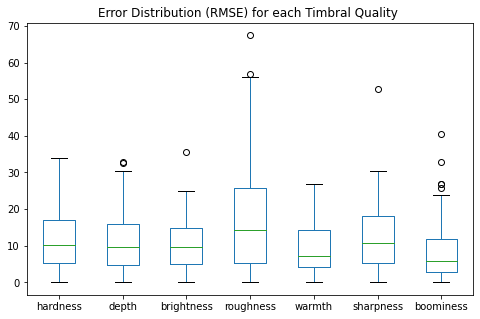

In [ ]:
# df_real = pd.read_csv("./new_timbral_real2.csv")

# df_recons = pd.read_csv("./new_timbral_reconstructed2.csv")
# df_recons.head()

# df_loss = pd.DataFrame()

# for col in df_real.columns[:-1]:
#     losses = []
#     for i in zip(df_real[col], df_recons[col]):
#         loss = np.sqrt(np.mean((float(i[1])-float(i[0]))**2))
#         # print(loss)
#         losses.append(loss)
    
#     df_loss[col] = losses
#     print(col, "-> mean:", df_loss[col].mean(), "std:", df_loss[col].std())

# df_loss.boxplot(grid=False, figsize=(8,5))
# plt.title("Error Distribution (RMSE) for each Timbral Quality ")
# plt.show()

# # plt.savefig("timbral_boxplot.svg", format="svg")

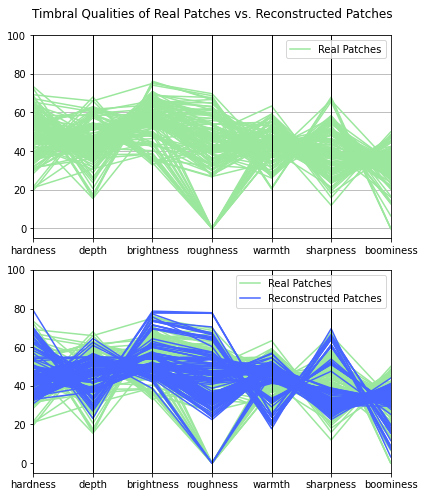

In [ ]:
# fig, axes = plt.subplots(2,1, figsize=(6,7))

# df_real = pd.read_csv("new_timbral_real.csv")
# df_recons = pd.read_csv("new_timbral_reconstructed2.csv")

# df_real = df_real.drop("reverb", axis=1)
# df_recons = df_recons.drop("reverb", axis=1)
# # df_real=df_real.drop("id", axis=1) # Remove the ID used to sort in another snippet.
# # df_recons=df_recons.drop("id", axis=1) # Remove the ID used to sort in another snippet.

# df_real['class'] = "Real Patches"
# df_recons['class'] = "Reconstructed Patches"

# parallel_coordinates(df_real, class_column="class", ax=axes[0], color="#9be79d")
# parallel_coordinates(df_real, class_column="class", ax=axes[1], color="#9be79d")
# parallel_coordinates(df_recons, class_column="class",ax=axes[1], color="#4666ff")

# plt.rcParams['axes.facecolor'] = 'white'
# axes[0].set_ylim(-5, 100)
# axes[1].set_ylim(-5, 100)

# fig.suptitle("Timbral Qualities of Real Patches vs. Reconstructed Patches")
# plt.tight_layout()
# plt.show()
